# Logs analysis - Data Pre-processing
by Chihebeddine H., data scientist

# Setup

In [1]:
# Data wrangling - Spark
from pyspark.sql.functions import udf, col, regexp_extract, regexp_replace, to_date
from pyspark.sql.types import IntegerType, TimestampType
from pyspark.sql import functions as F
from pyspark.sql import SparkSession


# Data wrangling - Python
import pandas as pd
import re
import numpy as np

# Sys
import gc
import os
from pathlib import Path
import datetime as dt
import pytz
import shutil

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ROOT_PATH = Path("..")
file_path = ROOT_PATH/"data"/"raw"/"access.log"

# Introduction

Given the increasing importance of online presence for companies and individual alike, the mission of protecting companies in the cyber-space against harmful bots is crucial. This challenge is proposed to work on a sample of real word log files to come up with innovative bot detection solutions. Log files are typically semi-structured massive data source that are produced by web servers upon a client request. They represent a wealth of information that can be leveraged to offer new services and protect companies, know better its clients and offer new services.

# Challenge objective
The objective of this challenge, is to build a scalable log processing pipeline to identify bots. Bots can be either good such as Web crawlers to keep web indexing up to date or harmful such as credentials stuffing bots using SQL injections.

# Pipeline overview

![My solution](../docs/figs/data_pipeline.png)

__Tech choice: I choose Spark as my main processing framework because my data pipeline can be easily scalable to larger data sets with minimal changes.__

In [9]:
# Accessing Spark UI to monitor and manage jobs
spark

# Getting data

In [10]:
## Uncomment to download data
# ! wget -P ../data/raw http://www.almhuette-raith.at/apache-log/access.log 

# Parsing log data

In [3]:
raw_logs = spark.read.text(file_path.__str__())

In [4]:
# Basic infos
raw_logs.printSchema()
n, p = raw_logs.count(), len(raw_logs.columns)
print(f"Dataset size: {n} rows and {p} column")

root
 |-- value: string (nullable = true)

Dataset size: 5015809 rows and 1 column


In [13]:
# Example of logs
logs_sample = [log["value"] for log in raw_logs.take(5)]
for log in logs_sample:
    print(log, "\n")

 

109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] "GET /administrator/ HTTP/1.1" 200 4263 "-" "Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0" "-" 

109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] "POST /administrator/index.php HTTP/1.1" 200 4494 "http://almhuette-raith.at/administrator/" "Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0" "-" 

46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] "GET /administrator/ HTTP/1.1" 200 4263 "-" "Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0" "-" 

46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] "POST /administrator/index.php HTTP/1.1" 200 4494 "http://almhuette-raith.at/administrator/" "Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0" "-" 



The provided log file consist of raw server log semi-structed that follow certain conventions. These conventions were provided and in the links below and I used them through regular expression to parse raw logs and extract useful features structured in a tablular format file handy for Exploratory data nalysis (EDA) or Machine Learning:
    * https://stackoverflow.com/questions/9234699/understanding-apaches-access-log
    * https://httpd.apache.org/docs/current/logs.html#combined 

In [4]:
def parse_logs(df):
    
    """
    Parse raw logs according to complete log naming convention
    
    Args:
    df: Spark DataFrame - raw logs
    
    Returns:
    parsed_df: Spark DataFrame: parsed logs
    """

    patterns = {
                "ip_address":"^([\S+\.]+\S+)",
                "user_id":"^[\S+\.]+\S+\s+(\S+)\s+",
                "user_name": '\s+(\S+)\s+\[\d+/\w+/\d+:\d+:\d+:\d+\s+[-+]?\d+]',
                "datetime": "\[(\d+/\w+/\d+:\d+:\d+:\d+\s+[-+]?\d+)]",
                "request": '"([A-Z]+\s+\S+\s+[A-Z]+\S+)"',
                "status_code": '\s+([2-5]{1}\d{2})\s+',
                "size": '\d+\s+(\d+)\s+\"',
                "referer": '\d+\s+\d+\s+"(\S+)"',
                "user_agent": '"\S+"\s+"([\S+\s+]+\S)"\s+\S+$',
                "last": '\s"(\S+)"$'
               }
    
    parsed_df = df
    for token_name in patterns:
        parsed_df = parsed_df.withColumn(token_name, regexp_extract('value', patterns[token_name], 1))

    return parsed_df

In [5]:
parsed_logs = parse_logs(raw_logs)
parsed_logs.printSchema()
print(f"Dataset size: {parsed_logs.count()} rows and {len(parsed_logs.columns)} column")

root
 |-- value: string (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- request: string (nullable = true)
 |-- status_code: string (nullable = true)
 |-- size: string (nullable = true)
 |-- referer: string (nullable = true)
 |-- user_agent: string (nullable = true)
 |-- last: string (nullable = true)

Dataset size: 5015809 rows and 11 column


# Check parsing

The main log parts are now parsed, let's check parsing results:

In [16]:
sample = sc.parallelize(parsed_logs.take(5)).toDF().toPandas()
sample.T

,0,1,2,3,4
value,,109.169.248.247 - - [12/Dec/2015:18:25:11 +010...,109.169.248.247 - - [12/Dec/2015:18:25:11 +010...,"46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] ""...","46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] ""..."
ip_address,,109.169.248.247,109.169.248.247,46.72.177.4,46.72.177.4
user_id,,-,-,-,-
user_name,,-,-,-,-
datetime,,12/Dec/2015:18:25:11 +0100,12/Dec/2015:18:25:11 +0100,12/Dec/2015:18:31:08 +0100,12/Dec/2015:18:31:08 +0100
request,,GET /administrator/ HTTP/1.1,POST /administrator/index.php HTTP/1.1,GET /administrator/ HTTP/1.1,POST /administrator/index.php HTTP/1.1
status_code,,200,200,200,200
size,,4263,4494,4263,4494
referer,,-,http://almhuette-raith.at/administrator/,-,http://almhuette-raith.at/administrator/
user_agent,,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...


In [18]:
def check_parsing(df):

    """
    Compute basic stats for parsed logs to check parsing for every extracted features
    
    Args:
    df: Spark DataFrame - parsed logs
    
    Returns:
    summary: Pandas DataFrame: basic statistics:
        - unmatched: number of unmatched string for <feature> pattern
        - n_uniques: Number of unique values
        - F.agg_fun(length): agg.func applied to length of extracted strings
    """
    
    features = [feature for feature, _ in df.drop("value").dtypes]
    types = [feat_type for _, feat_type in df.drop("value").dtypes]
    
    summary = {"type":[],
               "n_unmatched":[],
               "n_uniques":[],
               "n_missing":[],
               "min(length)":[],
               "avg(length)":[],
               "max(length)":[],
               "stddev_samp(length)":[],
              }
    summary = pd.DataFrame(summary)    
    len_udf = udf(lambda x: len(x), IntegerType())
    null_udf = udf(lambda x: None if x in ("","-",'"-"') else x)
    
    agg_funcs = (F.min("length"),F.avg("length"), F.max("length"),F.stddev("length"))
    
    for feature in features:
        
        summary.loc[feature,'n_unmatched'] = df.select(feature).where(col(feature)=="").count()
        summary.loc[feature,'n_uniques'] = df.select(feature).dropDuplicates().count()
        summary.loc[feature,'n_missing'] = df.select(feature).withColumn(feature, null_udf(feature)).\
                                            where(col(feature).isNull()).count()
        values = df.select(len_udf(feature).alias("length")).agg(*agg_funcs).collect()[0]
        summary.loc[feature,"min(length)"] = values["min(length)"]
        summary.loc[feature,"avg(length)"] = values["avg(length)"]
        summary.loc[feature,"max(length)"] = values["max(length)"]
        summary.loc[feature,"stddev_samp(length)"] = values["stddev_samp(length)"]

        
        
    summary["type"] = types

    return summary

In [19]:
parsing_stats = check_parsing(parsed_logs)
parsing_stats

,type,n_unmatched,n_uniques,n_missing,min(length),avg(length),max(length),stddev_samp(length)
ip_address,string,1.0,67706.0,1.0,0.0,12.810345,32.0,0.999150
user_id,string,1.0,2.0,5015809.0,0.0,1.000000,1.0,0.000447
user_name,string,1.0,77.0,5015657.0,0.0,1.000158,17.0,0.034410
datetime,string,1.0,1317607.0,1.0,0.0,25.999995,26.0,0.011609
request,string,108.0,225669.0,108.0,0.0,51.855074,6364.0,76.205967
status_code,string,1.0,16.0,1.0,0.0,2.999999,3.0,0.001340
size,string,8462.0,90428.0,8462.0,0.0,4.176431,10.0,0.960564
referer,string,9473.0,13933.0,2707413.0,0.0,21.961160,1561.0,26.950923
user_agent,string,489994.0,19293.0,489994.0,0.0,62.350385,6373.0,53.102748
last,string,1.0,2.0,5015809.0,0.0,1.000000,1.0,0.000447


In [20]:
parsing_stats.to_csv(ROOT_PATH/"data"/"raw"/"parsing_stats.csv",index=True, sep=";")

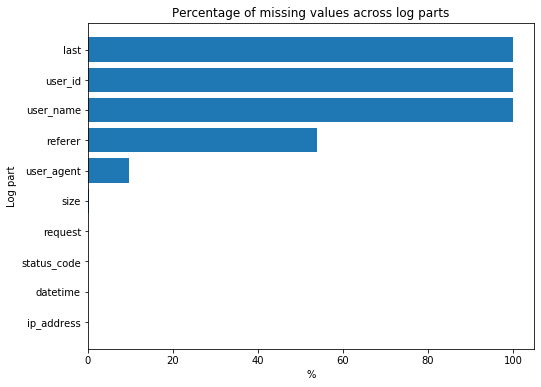

In [22]:
data = (100/n)*parsing_stats.n_missing.sort_values()
plt.figure(figsize=(8,6))
plt.barh(y = data.index, width=data.values)
plt.title("Percentage of missing values across log parts")
plt.xlabel("%")
plt.ylabel("Log part")
plt.show()

__Comments__

- ̀`ip_address`: IP address is well parsed with only one unmatched string (the 1st line of log file). There are 67706 unique IP address in this dataset, and average string length is consistent with IP convention except string length exceding  (3*4+3=15 for IPv4). After checking, it seems that there is a mix betwwen IP adresses and DNS naming for two logs that will be dropped.

- The figure above shows that `user_id`, `user_name` and `last` are systematically missing. These features will be dropped from my analysis.

- `referer` and `user_agent` are correctly parsed but are missing in 53.9% (resp. 9.7%) of cases. These features are important for detecting bot traffic and extracting other useful features.

- The remaining features `status_code`, `size`, `request` and `datetime` are seldom missing in this log files. However, their data types have to be correctly casted in the next step.


In [7]:
len_udf = udf(lambda x: len(x), IntegerType())
parsed_logs.\
    select("ip_address").\
    withColumn("ip_address_len", len_udf(col("ip_address"))).\
    filter(col("ip_address_len") > 15).\
    collect()

[Row(ip_address='217.216.115.198.dyn.user.ono.com', ip_address_len=32),
 Row(ip_address='217.216.115.198.dyn.user.ono.com', ip_address_len=32)]

# Data cleaning

In [107]:
def cast_utc(x):
    """
    Convert a datetime string to a string repecting 
    Spark default timestamp format
    
    Args: str
    Returns: str
    """
    datetime_format = "%d/%b/%Y:%H:%M:%S %z"
    local_dt = dt.datetime.strptime(x,datetime_format)
    utc_dt = local_dt.astimezone(pytz.UTC)
    utc_dt = utc_dt.strftime("%Y-%m-%d %H:%M:%S")
        
    return utc_dt


def clean_logs(df):
    
    """
    Clean parsed logs to drop unformative features, delete missing values
    cast features to appropriate data types
    
    Args: 
    df: Spark DataFrame
    
    Returns:
    clean_df: Spark DataFrame
    """

    # Force empty strings to null for all features
    null_udf = udf(lambda x: None if x in ("","-",'"-"') else x)
    cast_utc_udf = udf(lambda x: cast_utc(x))
    len_udf = udf(lambda x: 0 if x is None else len(x), IntegerType())

    clean_df = df
    
    # Drop Features:
    clean_df = clean_df.drop("last", "user_name", "user_id")

    # Force empty strings to NULL
    for feature in clean_df.columns:
        clean_df = clean_df.withColumn(feature, null_udf(col(feature)))
        
    # Cast to appropriate data types
    clean_df = clean_df.\
                filter(col("value").isNotNull()).\
                drop("value").\
                withColumn("size", col("size").cast("int")).\
                withColumn("datetime_utc", cast_utc_udf("datetime").cast("timestamp")).\
                withColumn("ip_address_len", len_udf("ip_address")).\
                filter(col("ip_address_len") <= 15).\
                drop("ip_address_len", "datetime")
    

    return clean_df
    

In [108]:
cleaned_logs = clean_logs(parsed_logs)

In [109]:
cleaned_logs.printSchema()

root
 |-- ip_address: string (nullable = true)
 |-- request: string (nullable = true)
 |-- status_code: string (nullable = true)
 |-- size: integer (nullable = true)
 |-- referer: string (nullable = true)
 |-- user_agent: string (nullable = true)
 |-- datetime_utc: timestamp (nullable = true)



Now that logs are parsed and checked, the next step is to drop uninformative features and instances, cast remaining ones to appropriate types such as:

- `size` -> Integer
- `datetime` -> UTC datetime

__Checking time zones__

Time zones of all logs are balanced between two main zones +1 UTC and +2 UTC).

In [112]:
time_zone_pattern = "([-+]?\d+$)"
parsed_logs.\
    select("datetime").\
    withColumn("time_zone", regexp_extract(col("datetime"),time_zone_pattern,1)).\
    filter(col("time_zone") != "").\
    groupBy("time_zone").\
    count().\
    toPandas()

,time_zone,count
0,+0200,2960514
1,+0100,2055294


# Save to Parquet file

In [113]:
file_path = (ROOT_PATH / "data" / "processed" /"cleaned_logs").__str__()
cleaned_logs.write.mode("overwrite").parquet(file_path)